## Условие задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Вызов бибиотек.

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import monthrange
from datetime import date
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score


from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

import sklearn as sklearn
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

## Функции.

In [2]:
#Определение пропусков
def nan (df):
    df_na = pd.DataFrame(df.isna().sum())
    df_na['percent'] = df_na[0] * 100 / len(df)
    df_na.columns = ['count', 'percent']
    return df_na[(df_na['percent'] > 0)].sort_values('percent', ascending = False)

#Диаграмма донат
def bublik(data, areas, index):
    areas =  areas
    for i in areas:
        data.pivot_table(index = index, values = [i],
          aggfunc = 'sum').sort_values([i], ascending = False).plot(y = i, 
          wedgeprops=dict(width=0.3), shadow=False, kind = 'pie', rotatelabels=True,
          label = i, autopct='%1.0f%%').legend(bbox_to_anchor=(1.1, 1))    
        
#Диаграмма boxplot_hue
def boxplot(data, x, y, hue):
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=x, y=y, hue=hue,
                 data=telecom, palette='Set3')
    plt.show()

#Просто график
def graph (data, x, y, name):
    plt.figure(figsize=(15, 10))
    sns.relplot(x=x, y=y, kind="line", data=data, height=5, aspect=3)
    plt.title(name, fontsize=16)
    plt.show()    
    
#Гистограмма датасета    
def hist (data):
    fig = plt.figure(figsize = (15,15))
    ax = fig.gca()
    data.hist(ax = ax)
    plt.show()
    
#Разделение выборок 
def split(data, target, first_size, second_size):
    features = data.drop(target, axis=1)
    target = data[target]
                 
    features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=first_size, random_state=42)
    features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=second_size, random_state=42)
    
    print('features_train', len(features_train))
    print('features_valid', len(features_valid))
    print('features_test', len(features_test))
    
    return features_test, target_test, features_train, target_train, \
    features_valid, target_valid

#Даунсемплинг
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    print('Баланс класса: 0 - ', round(target_downsampled.value_counts()[0] / (target_downsampled.value_counts().sum()/100)), '%')
    return features_downsampled, target_downsampled

#Апсэмплинг
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    print('Баланс класса: 0 - ', round(target_upsampled.value_counts()[0] / (target_upsampled.value_counts().sum()/100)), '%')
    return features_upsampled, target_upsampled

#Dалидация
def cv(model, X, y, scoring, cv):
    scores = cross_validate(model, X, y, cv=cv, 
                        scoring=(scoring),
                        return_train_score=False)
   
    return pd.DataFrame(scores)

## Загрузка данных.

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

# 1. Анализ данных.

### 1.1 Открою данные и изучу их.

### Данные контрактов.

In [4]:
contract[:4]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Данные пакета опций.

In [6]:
personal[:4]

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No


In [7]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


### Данные интернет пакета.

In [8]:
internet[:4]

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


### Данные пакета телефонии.

In [10]:
phone[:4]

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes


In [11]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


### 1.2 Проверю на пропуски.

In [12]:
nan(contract)

,count,percent


In [13]:
nan(personal)

,count,percent


In [14]:
nan(internet)

,count,percent


In [15]:
nan(phone)

,count,percent


### 1.3 Проверю на дупликаты.

In [16]:
print(phone['customerID'].duplicated().sum()),
print(contract['customerID'].duplicated().sum()),
print(personal['customerID'].duplicated().sum()),
print(internet['customerID'].duplicated().sum())

0
0
0
0


## Вывод

#### - 1. Даты требуют приведения к формату дат
#### - 2. TotalCharges требует приведения к формату чисел
#### - 3. Большинство значений булевы, остальные можно привести к категориям
#### - 4. Пропусков не обнаружено
#### - 5. Дупликатов не обнаружено

## Расширенное описание данных:

## contract
- customerID - код клиента
- BeginDate - дата начала использования услуг компании
- EndDate - дата окончания использования услуг компании
- Type - тип оплаты: ежемесячно, раз в год или раз в два года
- PaperlessBilling - выставляется ли счет электронным методом 
- PaymentMethod - способ оплаты
- MonthlyCharges - ежемесячный платёж (сумма)
- TotalCharges - сумма всех платежей

## personal
- customerID - код клиента
- gender - пол клиента
- SeniorCitizen - __неизвестно__
- Partner - __неизвестно__
- Dependents - __неизвестно__

## internet

- customerID - код клиента
- gender - пол клиента	
- SeniorCitizen	- __неизвестно__
- Partner - __неизвестно__
- Dependents - __неизвестно__

## phone

- customerID - код клиента
- MultipleLines - используется ли несколько линий

Всего контрактов 7043, интернетом пользуются 5517 пользователей, телефоном - 6361 пользователь.

<font color='blue'> 
# <u>ПЛАН РАБОТЫ</u>
</font>

###  1.  Предобработка данных.
    - 1.1  Привести форматы. Заменить NO/YES на 0/1.
    - 1.2  Добавить целевой признак.
    - 1.3  Добавить длительность контракта.
    - 1.4  Объеденить датасеты.
    - 1.5  Заполнить пропуски.
    - 1.6  Определить количество клиентов по услугам (комбинированные, только телефон, только интернет).
###  2.  Графический анализ данных. 
    - 2.1  Диаграмма распределения.
    - 2.2  Круговая диаграмма по категориям.
###  3.  Обучение модели.     
    - 3.1  Определить необходимость обучения модели по категориям клиентов (комбинированные, только телефон, только интернет).
    - 3.2  Выбрать метрику.
    - 3.3  Подобрать гиперпараметры.
    - 3.4  Обучить модели.
    - 3.5  Выбрать модель с лучшеми метриками.

<font color='blue'> 
# <u>1. Предобработка данных</u>
</font>

### 1.1 Форматирование Contract

In [17]:
contract.BeginDate = contract.BeginDate.astype('datetime64')
contract.EndDate = contract.EndDate.replace(to_replace=['No'], value=['2020-02-01'])
contract.EndDate = contract.EndDate.astype('datetime64')
contract.PaperlessBilling = contract.PaperlessBilling.replace(to_replace=['No', 'Yes'], value=[0, 1])
#TotalCharges содержит пропуски, заменю на ежемесяный платеж
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']
contract.TotalCharges = contract.TotalCharges.astype('float64')

### 1.2 Добавление целевого признака

In [18]:
contract['Lost'] = 1
contract.loc[contract['EndDate'] == '2020-02-01', 'Lost'] = 0

### 1.3 Добавление длительности контракта

In [19]:
contract['begin_year'] = pd.DatetimeIndex(contract['BeginDate']).year
contract['end_year'] = pd.DatetimeIndex(contract['EndDate']).year
contract['begin_month'] = pd.DatetimeIndex(contract['BeginDate']).month
contract['end_month'] = pd.DatetimeIndex(contract['EndDate']).month
contract['Months'] = ((contract['end_year']- contract['begin_year']) * 12 + \
                      (contract['end_month'] - contract['begin_month']))
#Дата окончания контракта больше нам не понадобится. Поэтому удалю.
contract = contract.drop(['begin_year','end_year','begin_month','end_month', 'BeginDate','EndDate'], axis=1)

In [20]:
contract[:3]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lost,Months
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,34
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,2


<font color='green'> 
### <u>Промежуточный вывод</u>
</font>

- Определен и добавлен целевой признак.
- Удалена дата ухода клиента и тем самым предотвращена утечка признака.
- Добавлено время лояльности клиента в месяцах.

### 1.4 Объеденю датасеты

In [21]:
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')
telecom = df.merge(internet, on='customerID', how='left')

In [22]:
telecom[:3]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,1,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,34,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,2,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No


### 1.4.1 Форматирование Telecom

In [23]:
telecom = telecom.replace(to_replace=['No', 'Yes'], value=[0, 1])

### 1.5 Заполнение пропусков

In [24]:
nan(telecom)

,count,percent
InternetService,1526,21.666903
OnlineSecurity,1526,21.666903
OnlineBackup,1526,21.666903
DeviceProtection,1526,21.666903
TechSupport,1526,21.666903
StreamingTV,1526,21.666903
StreamingMovies,1526,21.666903
MultipleLines,682,9.683374


In [25]:
telecom.InternetService = telecom.InternetService.fillna('Absent')
telecom.MultipleLines = telecom.MultipleLines.fillna('8')

In [26]:
telecom.Services = telecom.loc[telecom['MultipleLines'] == '8', 'Services'] = 'Internet_only'
telecom.Services = telecom.loc[telecom['InternetService'] == 'Absent', 'Services'] = 'Phone_only'
telecom['Services'] = telecom['Services'].fillna('Both')
telecom.MultipleLines = telecom.MultipleLines.replace(to_replace=['8'], value=['0'])
telecom = telecom.fillna('0')
telecom['add'] = 1

In [27]:
telecom[:2]

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Services,add
0,7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,1,Female,0,...,0,DSL,0,1,0,0,0,0,Internet_only,1
1,5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,34,Male,0,...,0,DSL,1,0,1,0,0,0,Both,1


<font color='green'> 
### <u>Промежуточный вывод</u>
</font>

- Датасеты объеденены по customerID.
- Бинарные признаки заменены на 1 и 0.
- __Заполнены пропуски:__
    - InternetService значением Absent по причине того, что пропуски актуальны для пользователей только телефонной связью
    - Оставшиеся на 0, так как значения отсутствуют по причине неиспользования интернет
    - MultipleLines на 0, так как имеющийся противоположный признак - 1

<font color='blue'> 
# <u>2. Графический анализ данных</u>
</font>

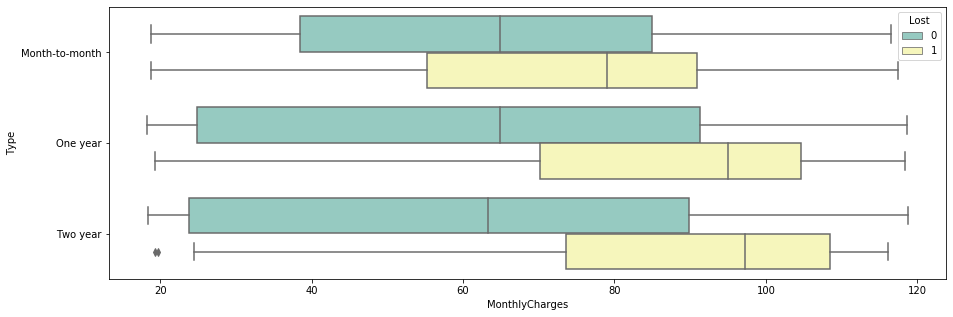

In [28]:
boxplot(telecom, "MonthlyCharges", "Type", "Lost")

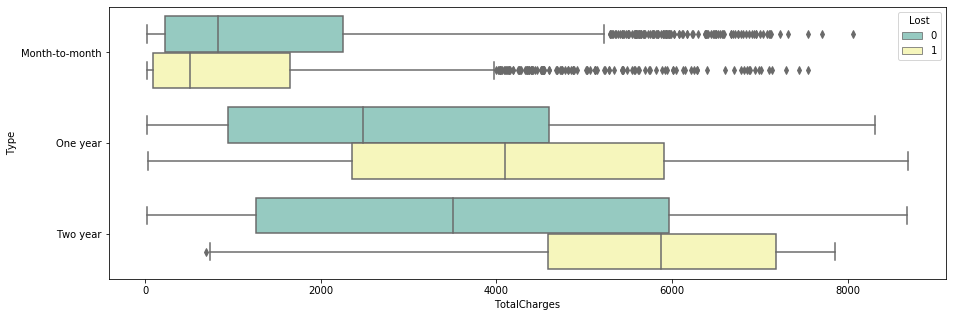

In [29]:
boxplot(telecom, "TotalCharges", "Type", "Lost")

### 2.1 Диаграмма распределения

In [30]:
m_m = telecom[(telecom['Lost'] ==1) & (telecom['Type'] == 'Month-to-month')].MonthlyCharges.describe()
year_1 = telecom[(telecom['Lost'] ==1) & (telecom['Type'] == 'One year')].MonthlyCharges.describe()
year_2 = telecom[(telecom['Lost'] ==1) & (telecom['Type'] == 'Two year')].MonthlyCharges.describe()
m_m_0 = telecom[(telecom['Lost'] ==0) & (telecom['Type'] == 'Month-to-month')].MonthlyCharges.describe()
year_1_0 = telecom[(telecom['Lost'] ==0) & (telecom['Type'] == 'One year')].MonthlyCharges.describe()
year_2_0 = telecom[(telecom['Lost'] ==0) & (telecom['Type'] == 'Two year')].MonthlyCharges.describe()

In [31]:
lost = {'Ушедший_Месячный': m_m, 'Ушедший_Годовой': year_1, 'Ушедший_Двухгодовой': year_2}
current = {'Клиент_Месячный': m_m_0, 'Клиент_Годовой': year_1_0, 'Клиент_Двухгодовой': year_2_0}

### 2.1.1 Распределение платежей текущих клиентов по тарифным планам

In [32]:
pd.DataFrame(data=current)

,Клиент_Месячный,Клиент_Годовой,Клиент_Двухгодовой
count,2220.000000,1307.000000,1647.000000
mean,61.462635,62.508148,60.012477
std,27.863547,31.659200,34.547327
min,18.750000,18.250000,18.400000
25%,38.537500,24.825000,23.775000
50%,64.950000,64.850000,63.300000
75%,84.912500,91.250000,89.850000
max,116.500000,118.600000,118.750000


### 2.1.2 Распределение платежей ушедших клиентов по тарифным планам

In [33]:
pd.DataFrame(data=lost)

,Ушедший_Месячный,Ушедший_Годовой,Ушедший_Двухгодовой
count,1655.000000,166.000000,48.000000
mean,73.019396,85.050904,86.777083
std,24.084146,25.641127,28.917883
min,18.850000,19.300000,19.350000
25%,55.200000,70.112500,73.650000
50%,79.050000,95.050000,97.275000
75%,90.875000,104.700000,108.450000
max,117.450000,118.350000,116.200000


<font color='green'> 
### <u>Промежуточный вывод</u>
</font>

- Из диаграммы видно:
    - Cредний чек ушедших клиентов выше.
    - Минимальные суммы платежей ушедших клиентов выше.
    - Потери происходят за счет клиентов с помесячной оплатой.

In [34]:
telecom.Lost = telecom.Lost.replace(to_replace=[0, 1], value=['current','lost'])

### 2.2 Доли потерь по тарифным планам.

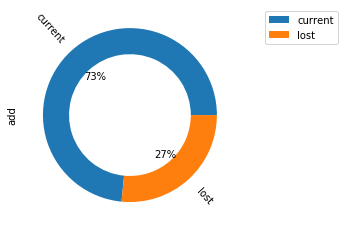

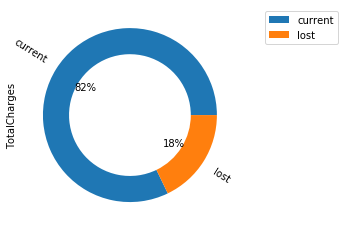

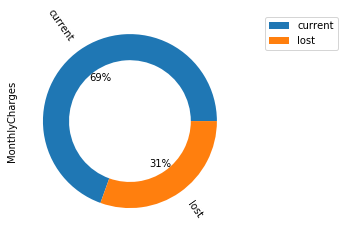

In [35]:
bublik(telecom, ['add', 'TotalCharges', 'MonthlyCharges'], 'Lost')

### Ушедшие составили:
- 18% от общего количества платежей
- 31% от месячного количества платежей

### 2.3 Доли распределения по сервисам .

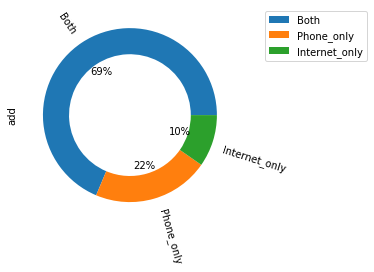

In [36]:
bublik(telecom, ['add'], 'Services')

### Сервисы распределились:
- 10% Только интернет
- 22% Только телефон
- 69% Оба сервиса

### 2.4 Доли платежей по ушедшим и действующим клиентам в зависимости от графика платежей.

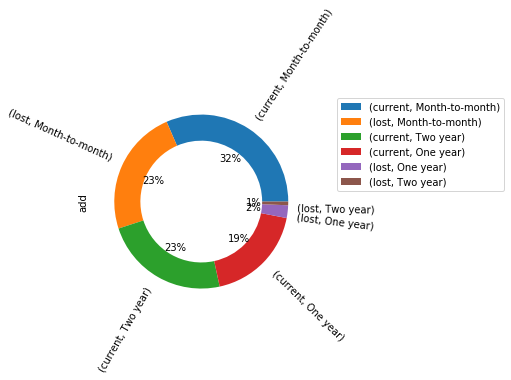

In [37]:
bublik(telecom, ['add'], ['Lost', 'Type'])

### 2.5 Наибольшие потери на месячном плане, тогда как на двухгодовом менее 1%

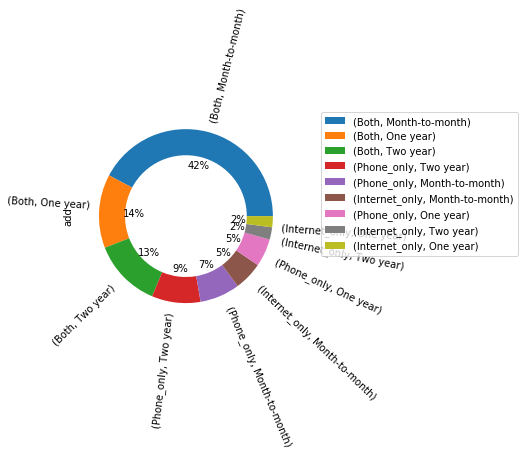

In [38]:
bublik(telecom, ['add'], ['Services', 'Type'])

### 2.6 Доля полов в ушедших и действующих клиентах.

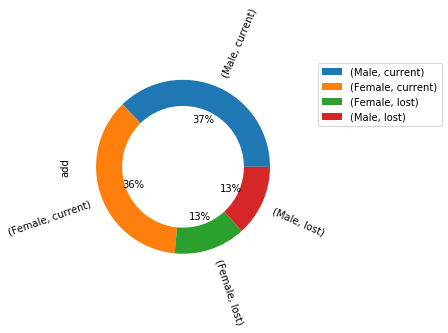

In [39]:
bublik(telecom, ['add'], ['gender', 'Lost'])

### Соотношение полов одинаковое и в действующих и в ушедших клиентах.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


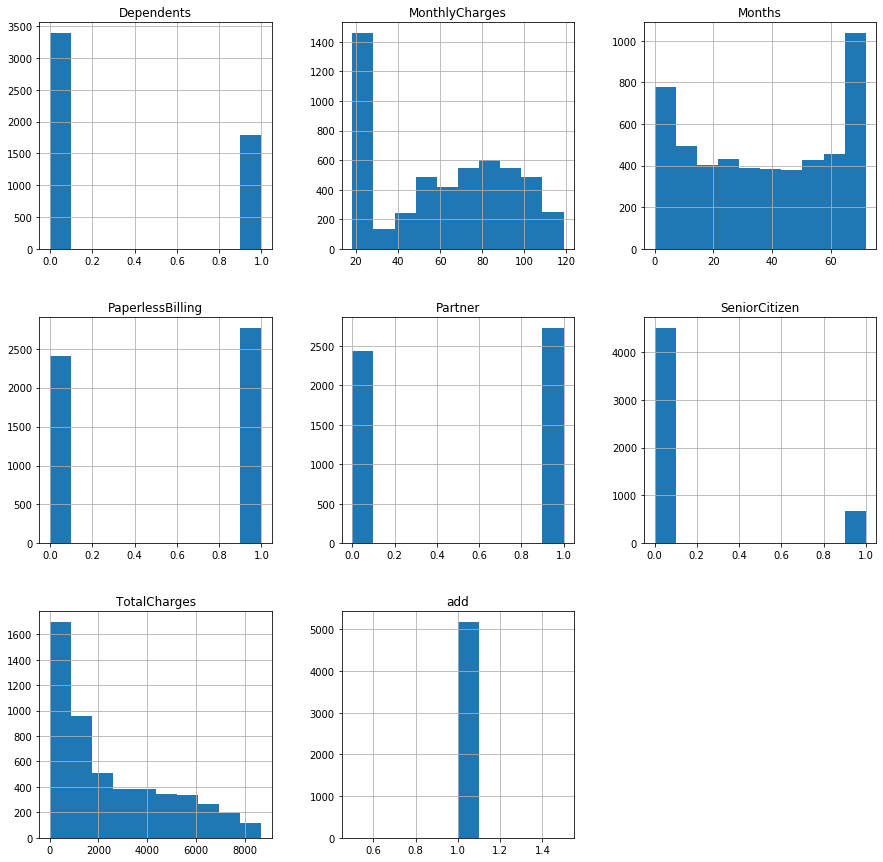

In [40]:
hist(telecom[telecom['Lost'] == 'current'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


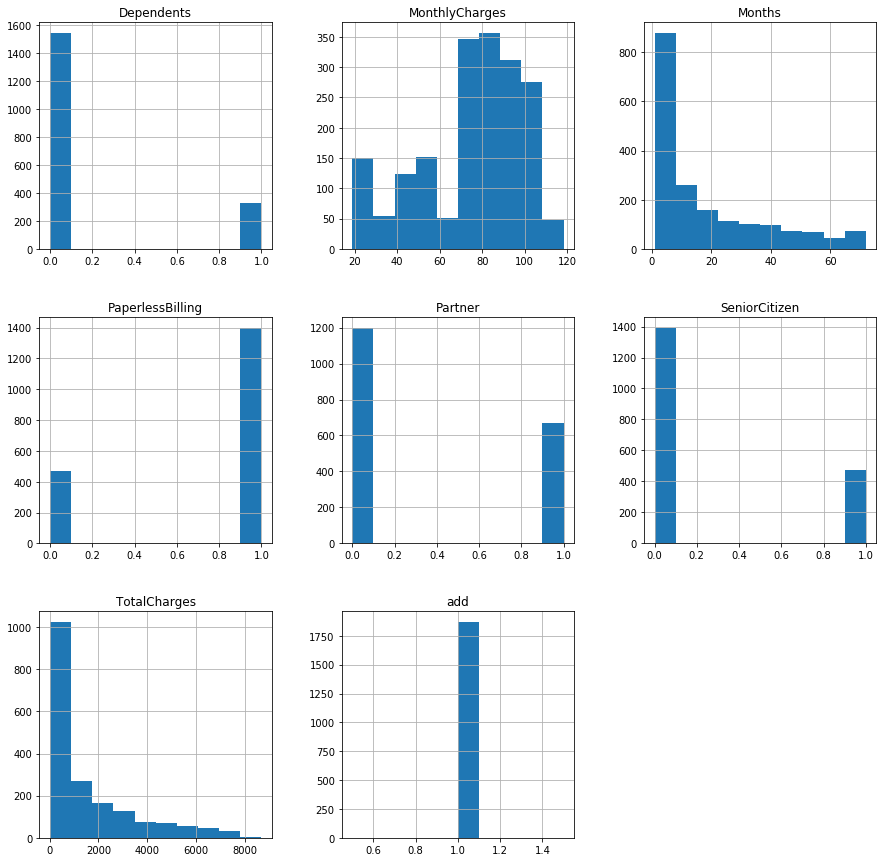

In [41]:
hist(telecom[telecom['Lost'] == 'lost'])

### Удаление лишнего признака

In [42]:
telecom.Lost = telecom.Lost.replace(to_replace=['current','lost'], value=[0, 1])
telecom.gender = telecom.gender.replace(to_replace=['Male','Female'], value=[0, 1])
telecom = telecom.drop(['add','customerID', ], axis=1)


In [43]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Lost                7043 non-null int64
Months              7043 non-null int64
gender              7043 non-null int64
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Services            7043 non-null object
dtypes: float64(2), int64(7), object(11)
memory usage: 1.4+ MB


In [44]:
telecom['new_1'] = telecom["OnlineSecurity"] + telecom["OnlineBackup"]  + telecom["DeviceProtection"] + telecom["TechSupport"] + telecom["StreamingTV"] 

In [45]:
def user(i):
    if i > 50:
        return 1

In [46]:
#telecom['new_2'] = telecom['Months'].apply(user).fillna(0)

In [47]:
telecom[:4]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,Partner,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Services,new_1
0,Month-to-month,1,Electronic check,29.85,29.85,0,1,1,0,1,...,0,DSL,0,1,0,0,0,0,Internet_only,1
1,One year,0,Mailed check,56.95,1889.50,0,34,0,0,0,...,0,DSL,1,0,1,0,0,0,Both,2
2,Month-to-month,1,Mailed check,53.85,108.15,1,2,0,0,0,...,0,DSL,1,1,0,0,0,0,Both,2
3,One year,0,Bank transfer (automatic),42.30,1840.75,0,45,0,0,0,...,0,DSL,1,0,1,1,0,0,Internet_only,3


In [48]:
#telecom = telecom.drop(["OnlineSecurity","OnlineBackup",
                        #"DeviceProtection","TechSupport", "StreamingTV", 'gender'], axis=1)

In [49]:
telecom[:3]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,Partner,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Services,new_1
0,Month-to-month,1,Electronic check,29.85,29.85,0,1,1,0,1,...,0,DSL,0,1,0,0,0,0,Internet_only,1
1,One year,0,Mailed check,56.95,1889.50,0,34,0,0,0,...,0,DSL,1,0,1,0,0,0,Both,2
2,Month-to-month,1,Mailed check,53.85,108.15,1,2,0,0,0,...,0,DSL,1,1,0,0,0,0,Both,2


In [50]:
target = telecom['Lost']
features = telecom.drop(['Lost'], axis=1)

### One hot encoding

In [51]:
ohe_columns = ['Type', 'PaymentMethod', 'InternetService', 'Services']
ohe = pd.get_dummies(telecom[ohe_columns], drop_first=True)
telecom = telecom.drop(['Type', 'PaymentMethod', 'InternetService', 'Services'], axis=1)
telecom = telecom.join(ohe)

### Standartization

In [52]:
#scaler = StandardScaler()
#std_columns = ["MonthlyCharges", "TotalCharges", "Months"]
#std_columns = ["MonthlyCharges", "TotalCharges"]
#scaler.fit(telecom[std_columns])
#telecom[std_columns] = scaler.transform(telecom[std_columns])

In [53]:
telecom

,PaperlessBilling,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,Partner,Dependents,MultipleLines,...,new_1,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,Services_Internet_only,Services_Phone_only
0,1,29.85,29.85,0,1,1,0,1,0,0,...,1,0,0,0,1,0,1,0,1,0
1,0,56.95,1889.50,0,34,0,0,0,0,0,...,2,1,0,0,0,1,1,0,0,0
2,1,53.85,108.15,1,2,0,0,0,0,0,...,2,0,0,0,0,1,1,0,0,0
3,0,42.30,1840.75,0,45,0,0,0,0,0,...,3,1,0,0,0,0,1,0,1,0
4,1,70.70,151.65,1,2,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,84.80,1990.50,0,24,0,0,1,1,1,...,4,1,0,0,0,1,1,0,0,0
7039,1,103.20,7362.90,0,72,1,0,1,1,1,...,3,1,0,1,0,0,0,1,0,0
7040,1,29.60,346.45,0,11,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0
7041,1,74.40,306.60,1,4,0,1,1,0,1,...,0,0,0,0,0,1,0,1,0,0


In [54]:
telecom = telecom.astype('float64')

In [55]:
telecom[:3]

,PaperlessBilling,MonthlyCharges,TotalCharges,Lost,Months,gender,SeniorCitizen,Partner,Dependents,MultipleLines,...,new_1,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,Services_Internet_only,Services_Phone_only
0,1.0,29.85,29.85,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,56.95,1889.50,0.0,34.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,53.85,108.15,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


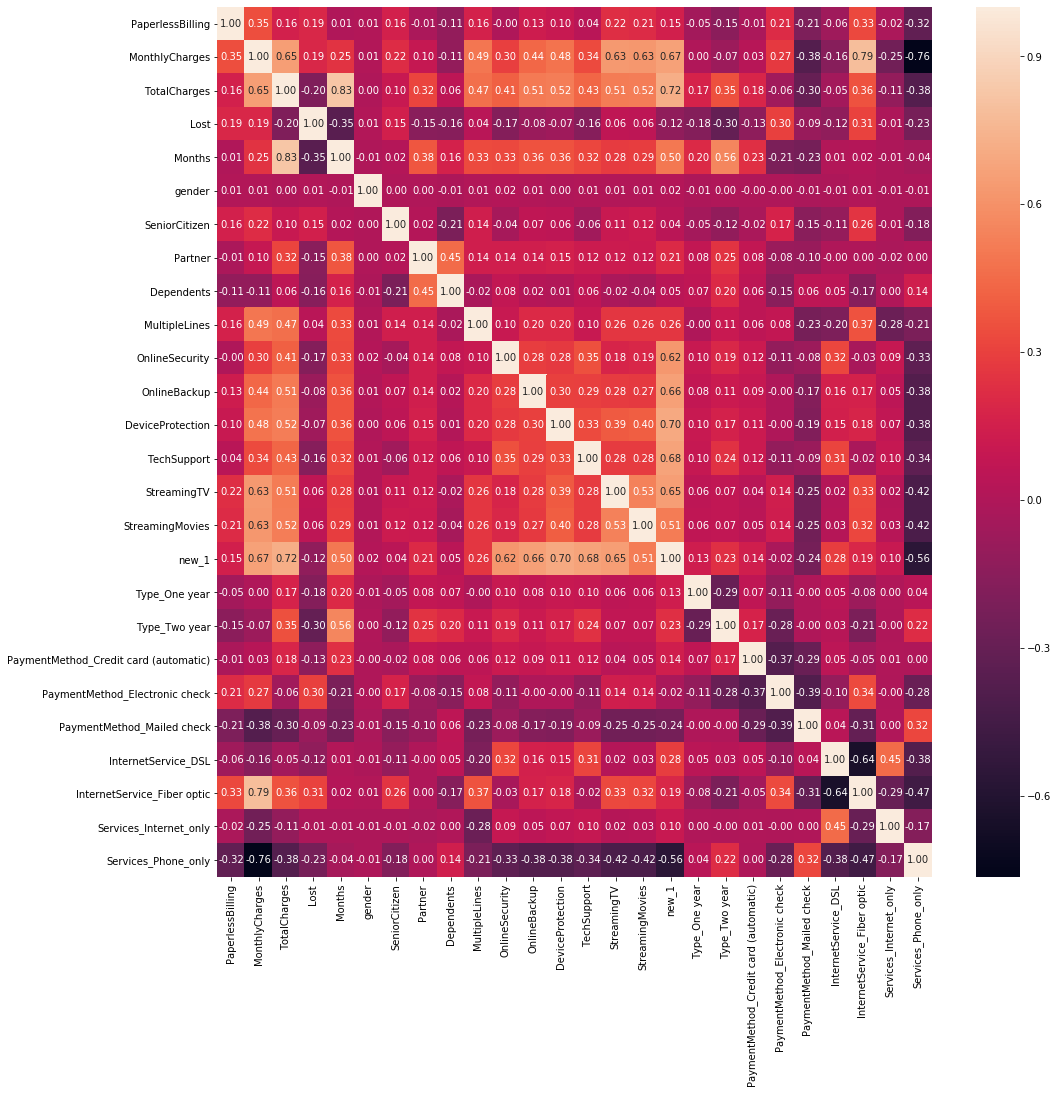

In [56]:
plt.figure(figsize=(16,16))
sns.heatmap(telecom.corr(), annot=True, fmt=".2f")

plt.show()

### Как видно из матрицы:
 - Присутствует мультиколлинеарность по признаку new_1 для параметров плана интьернет, что очевидно, так как признак является вычисляемым и введен для усиления этих признаков. В итоге он коррелирует сильнее с признаками платежей.
 - Признаки гендера фактически не влияют и их можно удалить.
 
 ## Вывод:
 - Я оставил все признаки, а также ввел заведомо мультиколлинеарный признак, чтобы поднять скор. В реальной ситуации, я бы использовал этот подход только при недостаточности данных. Если данных будет больше, я удалю признаки интернет тарифа для повышения стабильности модели

### Разделение выборок

In [57]:
features_test, target_test, \
features_train, target_train, \
features_valid, target_valid = split(telecom, 'Lost', .09, .1)

features_train 5768
features_valid 641
features_test 634


### Upsampling

In [58]:
print('Баланс класса: 0 - ', round(telecom.Lost.value_counts()[0] / \
                                   (telecom.Lost.value_counts().sum()/100)), '%')

Баланс класса: 0 -  73 %


In [59]:
features_train, target_train = upsample(features_train, target_train, 3)

Баланс класса: 0 -  48 %


### Обучение

In [60]:
#estimator = lgb.LGBMClassifier(class_weight='balanced', boosting_type = 'gbdt', 
                               #objective='binary', random_state=42, reg_alpha = 0, 
                               #metric = 'auc', max_depth = 1, silent=True)

#param_grid = { 'learning_rate': [0.1, 0.5 ,0.7], 'max_depth':   [x for x in range (1,20)],
              #'n_estimators': [x for x in range (100, 1000)], 'min_child_samples' : [x for x in range (1, 3)], 
              #'max_depth':   [x for x in range (1, 3)], 'reg_alpha': [x for x in range (9, 12)], 
              #'min_data_in_leaf': [x for x in range (25, 30)], 'max_bin': [x for x in range (18, 23)]

              #}

#cv =KFold(random_state=12345, n_splits=7) 
#gbm = GridSearchCV(estimator, param_grid, cv=cv, scoring='roc_auc')

#gbm.fit(features_train, target_train) 

#print('Best parameters is:', gbm.best_params_) 
#print('Best score is:', gbm.best_score_)

In [61]:
score_result = pd.DataFrame(columns = ['model', 'roc_auc_valid', 'roc_auc_test', 
                                       'recall_valid', 'recall_test', 
                                       'accuracy_valid', 'accuracy_test'])


In [62]:
LGBMClassifier = lgb.LGBMClassifier(learning_rate=0.4, max_depth=3, n_estimators=100, min_child_samples = 1,
                               reg_alpha = 11, objective='binary', metric = 'auc', random_state=4567,
                              min_data_in_leaf = 28, max_bin=20).fit(features_train, target_train)


probabilities_valid = LGBMClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
               
probabilities_test = LGBMClassifier.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

score_result.loc[0,'model'] = 'LGBMClassifier'
score_result.loc[0,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
score_result.loc[0,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)               
score_result.loc[0,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
score_result.loc[0,'recall_test'] = recall_score(target_test, probabilities_one_test.round())               
score_result.loc[0,'accuracy_valid'] = accuracy_score(target_valid, probabilities_one_valid.round())
score_result.loc[0,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())
score_result

print(confusion_matrix(target_test, probabilities_one_test.round()))
print(confusion_matrix(target_valid, probabilities_one_valid.round()))

[[334 128]
 [ 22 150]]
[[343 119]
 [ 28 151]]


<Figure size 1440x1440 with 0 Axes>

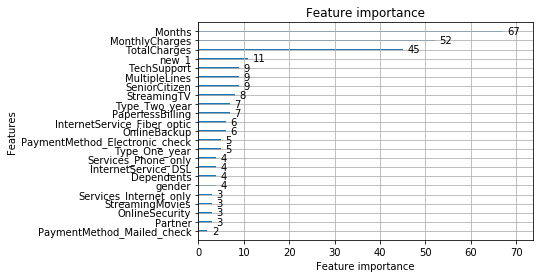

In [63]:
from lightgbm import plot_importance
plt.figure(figsize=(20, 20))
plt.show(plot_importance(LGBMClassifier))

In [64]:
#estimator = CatBoostClassifier(eval_metric='AUC')

#param_grid = {'learning_rate': [.005, .006, .007], 'max_depth': [2, 4, 16], 
              #'l2_leaf_reg': [x for x in range (1,8)], 'max_bin': [x for x in range (8,14)]
              
             #}

#result = estimator.grid_search(grid, X=features_train, y=target_train, plot=True)


In [65]:
CatBoostClassifier = CatBoostClassifier(eval_metric='AUC', random_state=4588, learning_rate = 0.006, 
                                        l2_leaf_reg=5, max_depth=4, max_bin=12)

CatBoostClassifier.fit(features_train, target_train, verbose=1000, plot=False)

probabilities_valid = CatBoostClassifier.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

probabilities_test = CatBoostClassifier.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

score_result.loc[1,'model'] = 'CatBoostClassifier'
score_result.loc[1,'roc_auc_valid'] = roc_auc_score(target_valid, probabilities_one_valid)
score_result.loc[1,'roc_auc_test'] = roc_auc_score(target_test, probabilities_one_test)               
score_result.loc[1,'recall_valid'] = recall_score(target_valid, probabilities_one_valid.round())
score_result.loc[1,'recall_test'] = recall_score(target_test, probabilities_one_test.round())               
score_result.loc[1,'accuracy_valid'] = accuracy_score(target_valid, probabilities_one_valid.round())
score_result.loc[1,'accuracy_test'] = accuracy_score(target_test, probabilities_one_test.round())
score_result

print(confusion_matrix(target_test, probabilities_one_test.round()))
print(confusion_matrix(target_valid, probabilities_one_valid.round()))

0:	total: 53.1ms	remaining: 53.1s
999:	total: 19.8s	remaining: 0us
[[335 127]
 [ 24 148]]
[[334 128]
 [ 27 152]]


In [66]:
#from catboost import Pool
#from catboost import CatBoostClassifier
#cat_features = [i for i, (col, ser) in enumerate(features_train.iteritems()) if ser.dtype == object]
#feature_score = pd.DataFrame(list(zip(features_train.dtypes.index, CatBoostClassifier.get_feature_importance(Pool(data=features_train.values.astype('int'), label=target_train.values.astype('int'), cat_features=cat_features)))),
#                columns=['Feature','Score'])
#feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
#plt.rcParams["figure.figsize"] = (12,7)
#ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
#ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
#ax.set_xlabel('')

#rects = ax.patches

#labels = feature_score['Score'].round(2)

#for rect, label in zip(rects, labels):
#    height = rect.get_height()
#    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

#plt.show()

### Не знаю по какой причине, но код выше в ноутбуке яндекса у меня не срабатывает. Поэтому ниже скрин с локальной машины)

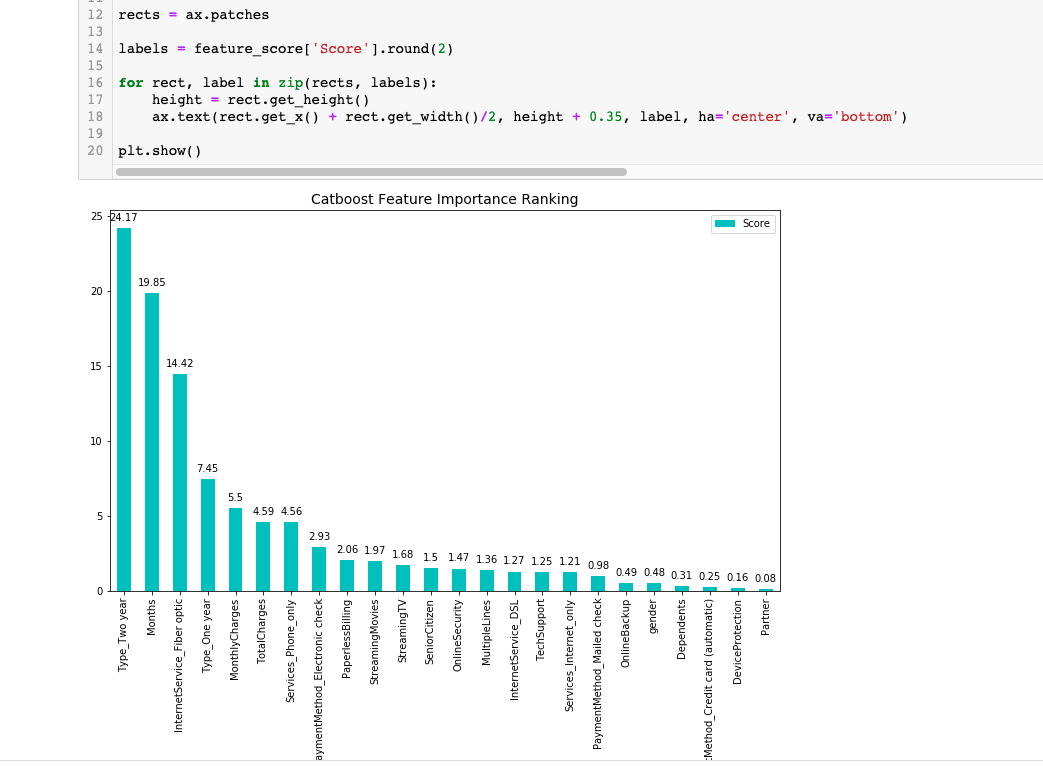

In [67]:
from IPython.display import Image
Image('screen.png')

In [68]:
score_result

,model,roc_auc_valid,roc_auc_test,recall_valid,recall_test,accuracy_valid,accuracy_test
0,LGBMClassifier,0.871182,0.871816,0.843575,0.872093,0.770671,0.763407
1,CatBoostClassifier,0.868945,0.880153,0.849162,0.860465,0.75819,0.76183


# Вывод:

## Самый высокий скор 0.880015 показал кэтбуст на тестовой выборке, но LGBMClassifier показывает большую стабильность на валидационной и тестовой выборках. Для окончательного решения о применении модели проведу сравнение медиан времени обучения и скоров

In [69]:
def cv(model, X, y, scoring, cv):
    scores = cross_validate(model, X, y, cv=cv, 
                        scoring=(scoring),
                        return_train_score=False)
   
    return pd.DataFrame(scores)

In [70]:
LGBMClassifier_cv = cv(LGBMClassifier, features_valid, target_valid, ['roc_auc', 'accuracy'], 50)

In [71]:
LGBMClassifier_cv.median()

fit_time         0.180605
score_time       0.097476
test_roc_auc     0.888889
test_accuracy    0.785714
dtype: float64

In [72]:
#CatBoostClassifier_cv = cv(CatBoostClassifier, features_valid, target_valid, ['roc_auc', 'accuracy'], 50)

# Вывод:
## Обе модели на кроссвалидации из 50 предсказаний показали высокий медианный скор. При этом CatBoostClassifier показал скор roc_auc = 0.900000 и accuracy 0.833333. 
## Даже при большей скорости обучения CatBoostClassifier, на существующем объеме данных предпочтительной является CatBoostClassifier.

### Какие пункты плана были выполнены, а какие — нет (поясните почему)?


 - Все пункты плана были выполнены. Нумерация сохранена в соответсвии с пунктами плана


### Какие трудности возникли и как вы их преодолели?

 - Первичная проверка на валидационной и тестовой выборке показала нестабильность модели. Разбиение сильно влияло на итоговый скор, который различался на 0,02 пункта по выборкам. Для повышения стабильности добавил дополнительный зависимый признак.
 
### Какие ключевые шаги в решении задачи выделили?

 - Выделение признака
 - Добавление features количества месяцев
 - OHE кодирование
 - Балансировка классов
 - Подбор параметров
 
### Какая ваша итоговая модель и какое у неё качество?

 - Матрица ошибок у CatBoostClassifier показывает, что эта модель - лидер по поиску истинноположительных ответов. При этом финальный скор и кроссвалидация говорит о том, что она с вероятностью 0,9 найдет тех клиентов, которые собираются уйти. 
 - Accuracy и ROC-AUC  LGBMClassifier хуже чем у CatBoost, но в целом, значение удовлетворяет поставленной задаче.
 - Выбор в данном датасете отдам CatBoost. В случае если объём данных увеличится и скорость станет важна, можно использовать LGBMClassifier


### Итоговая метрика


In [74]:
score_result

,model,roc_auc_valid,roc_auc_test,recall_valid,recall_test,accuracy_valid,accuracy_test
0,LGBMClassifier,0.871182,0.871816,0.843575,0.872093,0.770671,0.763407
1,CatBoostClassifier,0.868945,0.880153,0.849162,0.860465,0.75819,0.76183
